#From Linear classifiers to SVMs
** Ecole Centrale Nantes **

** Diana Mateus **





In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

#Modules for image processing
import skimage
from skimage import io
from skimage.color import rgb2gray
from skimage.transform import resize

#Modules for machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve

#Useful for manual data splitting
import random
from sklearn.utils import shuffle


# 1. Loading and splitting data

**a)** Download the animals10classes dataset from hippocampus, which is a subset of the Caltech 101 dataset (http://www.vision.caltech.edu/Image_Datasets/Caltech101/Caltech101.html). The animals subset is composed of images belonging to one among 10 classes. Run the code bellow to check images and labels are read correctly and store the name of the classes in the list ```labelNamesAll```. If present after unziping the dataset, remove the _MACOSX directory as it is not needed.

In [3]:
# Uncomment if using COLAB  (and comment next cell)
#from google.colab import drive
#drive.mount('/content/drive')
#IMDIR = ('/content/drive/MyDrive/DATA/animals10classes')


In [5]:
# Uncomment if running locally (comment if running in COLAB)
# Change with your own path
#IMDIR = '//data-pfe/overnet2022/EI2/APSTA/TP2/animals10classes/'
IMDIR = '//data-pfe/dchounlamo2022/CENTRALE_EI2/APSTA/animals10classes/'

# For Windows OS use IMIDR=r'/Users/dianamateus/DATA/101Caltech/animals10classes/'

In [6]:
#Keep4students
def loadImagesAndLabels(IMDIR):
  #This function glances through all subdirectories in IMDIR,
  #and creates a list of the subdirectory names, which will be
  #used as labels for all the images within.The function returns
  #the list of labels
  #
  #If the function returns an empty list, it is likely that IMDIR
  #is not defined correctly. In that case uncomment the lines below
  #to check the files that are actually being read.

  labelNamesAll = []

  for root, dirnames, filenames in os.walk(IMDIR):
      labelNamesAll.append(dirnames)
      #uncomment to check if the folder contains images
      #for filename in filenames:
      #   f = os.path.join(root, filename)
      #   if f.endswith(('.png', '.jpg', '.jpeg','.JPG', '.tif', '.gif')):
      #       print(f)

  labelNamesAll = labelNamesAll[0]
  return labelNamesAll

#Call the function and
#print the list of all labels/subdirectories
labelNamesAll = loadImagesAndLabels(IMDIR)
print(labelNamesAll)


['ant', 'butterfly', 'crayfish', 'crocodile', 'dragonfly', 'flamingo', 'lobster', 'octopus', 'sea_horse', 'starfish']


**b).** Use the BuildDataset function to create a reduced dataset. In this notebook we will notably deal with binary classification problems. Print the sizes of the data matrix X and the label vector Y. Print as well the retained list of labels and the content of Y.

In [7]:
#Keep4students
def buildDataset (IMDIR,labelNamesAll,K=2,N=100,imHeight=100,imWidth=100,seed=50):
    #This function builds the data matrix from (a subset) of the label list.
    #Images are read using a composition of the path and the label list.
    #Parameters of this functions are:
    # K : the number of classes to consider
    # N : the maximum number of images to read from each category (the number
    #    of images per label is variable).
    # imHeight,imWidth: define the size of the target image. All read images
    #                  are resized to imHeight x imWidth
    # seed : fixes the random seed to be able to reproduce the results.
    # The function returns the data matrix X and the label vector Y.
    # Ideally, the X matrix will be of size (KxN)x(ImHeight x ImWidth) but
    # the number of rows will be less if there number of images in a given
    # category is smaller than N

    X = np.zeros([K*N,imHeight*imWidth]) #data matrix, one image per row
    Y = -np.ones([K*N,1]) #label indices initiallized to -1
    labelNames = [] #list of retained categories

    random.seed(a=seed) #comment to make each run random

    globalCount = 0 #counts the actual number of images copied to the datamatrix

    # Iterate over the number of classes
    for i in range(K):
        #Randomly choose a new category
        while True:
            lab = random.randint(0,len(labelNamesAll)-1)
            if lab not in labelNames:
                break

        #define the path to read the images of the chosen label.
        #folders are named after the class label, print the chosen label
        filedir = os.path.join(IMDIR,labelNamesAll[lab])
        print('The chosen label ',i, ' is ',labelNamesAll[lab])
        print('It will be read in',filedir)

        #save the name of the class in labelNames
        labelNames.append(labelNamesAll[lab])

        #walk through the files of the label folder,
        #read images in grayscale and resize them
        #flatten the images to a vector
        #copy each image to one row of the data matrix
        #use classCount to retain at most N images per class
        #use globalCount to keep track of the total number of images
        classCount = 0
        for filename in os.listdir(filedir):
            f = os.path.join(filedir, filename)
            if f.endswith(('.jpg')) and (classCount < N):
                image = skimage.io.imread(f, as_gray=True)
                image = skimage.transform.resize(image, [imHeight,imWidth],mode='constant')#,anti_aliasing=True)
                X[globalCount,:] = image.flatten()
                Y[globalCount,:] = i
                globalCount += 1
                classCount += 1

    #Remove the unused entries of X and Y
    print("Total number of samples",globalCount)
    X = X[:globalCount,:]
    Y = Y[:globalCount,:]

    return X,Y,labelNames

In [8]:
K=2
imHeight=100
imWidth=100

#Call the buildDataset function

X,Y,labelNames = buildDataset (IMDIR,labelNamesAll,K=2,N=100,imHeight=100,imWidth=100,seed=50)

#Check the built dataset classes
print("Used labels",labelNames)
print("Size of data matrix", X.shape)
print("Class labels", Y.T)


The chosen label  0  is  octopus
It will be read in //data-pfe/dchounlamo2022/CENTRALE_EI2/APSTA/animals10classes/octopus
The chosen label  1  is  dragonfly
It will be read in //data-pfe/dchounlamo2022/CENTRALE_EI2/APSTA/animals10classes/dragonfly
Total number of samples 103
Used labels ['octopus', 'dragonfly']
Size of data matrix (103, 10000)
Class labels [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1.]]


**c)** Split the dataset into a train (80% of samples) and a test set (20% samples) subsets.

In [10]:
#PUT your code here, and check the obtained matrices

M,_ = np.shape(X)

m = round(M*0.8)

lignes_training_set = random.sample(range(0,M), min(m,M))
lignes_training_set.sort()
lignes_testing_set = np.setdiff1d(np.arange(M),lignes_training_set) #liste complémentaire
#print(lignes_training_set)
#print(lignes_testing_set)

X_train = X[lignes_training_set,:]
X_test =  X[lignes_testing_set,:]
Y_train = Y[lignes_training_set,0]
Y_test = Y[lignes_testing_set,0]

print("size of train dataset",X_train.shape)
print("size of test dataset",X_test.shape)
print("train target vector",Y_train.T)
print("test target vector",Y_test.T)

size of train dataset (82, 10000)
size of test dataset (21, 10000)
train target vector [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
test target vector [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


# 2. Support Vector Machines

**a) Linear SVM** Create an SVC model with a linear kernel and default values ``svmLin=SVC(kernel='linear')``.

* Fit the SVC on the training dataset and make predictions on the test set. Is it necessary to normalize the features in this case?
* Print the vector of ground truth values and the vector of predictions.
* Compute  the number of errors made.
* Use the SVC.score() function. Which is the metric being computed?
* Activate the probability ``svmLin = SVC(kernel='linear',probability=True)``.
* Make probabilistic predictions ``svmLin.predict_proba``
* How are these probabilities computed? (check the documentation)



In [11]:
# Create, train and test an svm model

svmLin=SVC(kernel='linear')
svmLin.fit(X_train, Y_train)
Y_pred=svmLin.predict(X_test)

err=abs(Y_pred-Y_test)
nb_err=sum(err) #car les classes sont 0 et 1

score=svmLin.score(X_test,Y_pred) 


print('Vecteur valeurs vraies :',Y_test)
print('Vecteur de prédictions :',Y_pred)
print('Il y a eu ',nb_err,' erreurs')
print('Le score SVC est de ', score)

# Create, train and test a "probabilistic" SVM model
svmLin2 = SVC(kernel='linear',probability=True)
svmLin2.fit(X_train,Y_train)
Y_pred_proba=svmLin2.predict_proba(X_test)

print('')
print('Vecteur de prédictions probabilistes :',Y_pred_proba)


Vecteur valeurs vraies : [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Vecteur de prédictions : [1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
Il y a eu  7.0  erreurs
Le score SVC est de  1.0

Vecteur de prédictions probabilistes : [[0.23133671 0.76866329]
 [0.14074804 0.85925196]
 [0.18416829 0.81583171]
 [0.1630854  0.8369146 ]
 [0.69497542 0.30502458]
 [0.3152918  0.6847082 ]
 [0.09766716 0.90233284]
 [0.78229148 0.21770852]
 [0.33278867 0.66721133]
 [0.18855159 0.81144841]
 [0.18209882 0.81790118]
 [0.41665819 0.58334181]
 [0.09455153 0.90544847]
 [0.17850749 0.82149251]
 [0.28499823 0.71500177]
 [0.4347396  0.5652604 ]
 [0.18610665 0.81389335]
 [0.04877574 0.95122426]
 [0.35258695 0.64741305]
 [0.35970978 0.64029022]
 [0.32037512 0.67962488]]


**b) Support vectors**
* How many parameters does the **model** have? (Hint: the answer is not SVC.get_params())
* How many hyperparameters?
* How many support vectors?
* Display some of the support vectors. Hint: use ``plt.imshow``
* How can you compute the linear model parameters from the dual coefficients SVC.dual_coef_?


Le nombre de paramètres du modèle est 10000
Le nombre d hyperparamètres est 1 : C
Il y a  62  vecteurs de support
Le nombre de vecteurs support pour chaque classe est 25 et 37


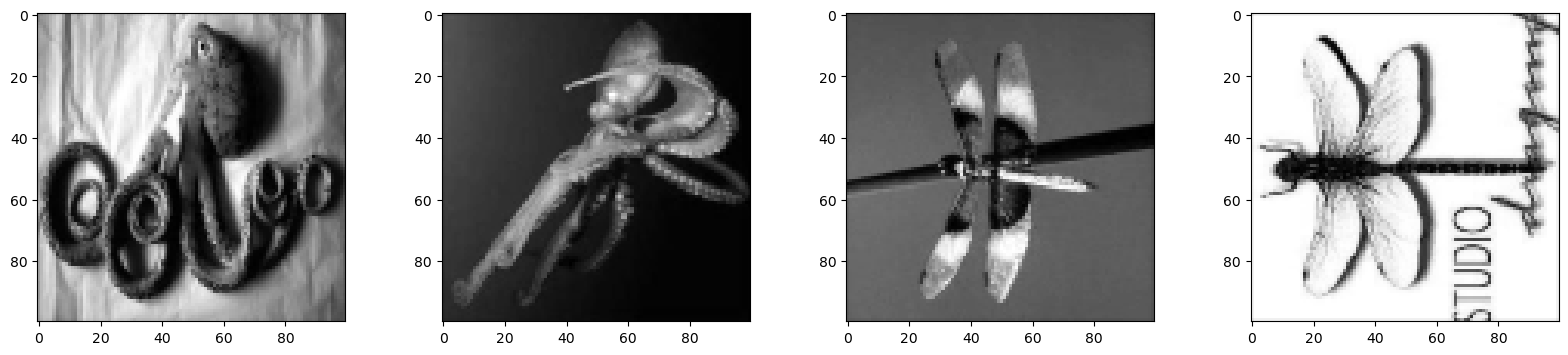

In [42]:
#coef1,coef2=np.shape(svmLin.coef_)
nb_param=len(svmLin.coef_.transpose())
nb_sv=svmLin.n_support_

print('Le nombre de paramètres du modèle est',nb_param)
print('Le nombre d hyperparamètres est 1 : C')
print('Il y a ',len(svmLin.support_vectors_), ' vecteurs de support')
print('Le nombre de vecteurs support pour chaque classe est',nb_sv[0], 'et',nb_sv[1])



##Affichage de quelques vecteurs de support

support_vector6=np.reshape(svmLin.support_vectors_[6],(100,100))
support_vector20=np.reshape(svmLin.support_vectors_[20],(100,100))
support_vector31=np.reshape(svmLin.support_vectors_[31],(100,100))
support_vector44=np.reshape(svmLin.support_vectors_[44],(100,100))

plt.figure(figsize=(20,4))
plt.subplot(141)
plt.imshow(support_vector6, cmap='gray')
plt.subplot(142)
plt.imshow(support_vector20, cmap='gray')
plt.subplot(143)
plt.imshow(support_vector31, cmap='gray')
plt.subplot(144)
plt.imshow(support_vector44, cmap='gray')



**c) Kernel SVMs.**
* Train three additional SVC models each using one among the kernel functions:
```
'kernel': ['rbf','poly', 'sigmoid'],
```
keep all other parameters to their default value.
* Report the number of support vectors found after fitting
* What are the hyperparameters available in each case?
* Report the number of errors and the accuracy for each model

In [13]:
svmLin_rbf=SVC(kernel='rbf')
svmLin_rbf.fit(X_train, Y_train)
Y_pred_rbf=svmLin_rbf.predict(X_test)
err_rbf=abs(Y_pred_rbf-Y_test)
nb_err_rbf=sum(err_rbf)
nb_pred = len(X_test)
score_rbf=svmLin_rbf.score(X_test,Y_pred) 
nb_supp_vect_rbf=len(svmLin_rbf.support_vectors_)
accuracy_rbf = 1 - nb_err_rbf/nb_pred

nb_hyper_params_rbf=len(svmLin_rbf.get_params())
nb_sv_rbf=svmLin_rbf.n_support_


print('RBF')
print('Vecteur valeurs vraies :',Y_test)
print('Vecteur de prédictions :',Y_pred_rbf)
print('Il y a ', nb_supp_vect_rbf, ' vecteurs de support')
print('Le nombre de vecteurs support pour chaque classe est',nb_sv_rbf[0], 'et',nb_sv_rbf[1])
print('Il y a eu ',nb_err_rbf,' erreurs')
print('Le score SVC est de ', score_rbf)
print('Accuracy est de ', accuracy_rbf)
print('Les hyperparamètres disponibles sont : C et gamma')

RBF
Vecteur valeurs vraies : [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Vecteur de prédictions : [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Il y a  71  vecteurs de support
Le nombre de vecteurs support pour chaque classe est 27 et 44
Il y a eu  8.0  erreurs
Le score SVC est de  0.8571428571428571
Accuracy est de  0.6190476190476191
Les hyperparamètres disponibles sont : C et gamma


In [38]:
svmLin_poly=SVC(kernel='poly')
svmLin_poly.fit(X_train, Y_train)
Y_pred_poly=svmLin_poly.predict(X_test)
err_poly=abs(Y_pred_poly-Y_test)
nb_err_poly=sum(err_poly)
nb_pred=len(X_test)
score_poly = svmLin_poly.score(X_test, Y_pred_poly)
nb_supp_vect_poly=len(svmLin_poly.support_vectors_)
accuracy_poly=1 - nb_err_poly/nb_pred

nb_hyper_param_poly=len(svmLin_poly.get_params())
nb_sv_poly=svmLin_poly.n_support_

print('POLY')
print('Vecteur valeurs vraies :',Y_test)
print('Vecteur de prédictions :',Y_pred_poly)
print('Il y a ', nb_supp_vect_poly, ' vecteurs de support')
print('Le nombre de vecteurs support pour chaque classe est',nb_sv_poly[0], 'et',nb_sv_poly[1])
print('Il y a eu ',nb_err_poly,' erreurs')
print('Le score SVC est de ', score_poly)
print('Accuracy est de ', accuracy_poly)
print('Les hyperparamètres disponibles sont : C, le degré et le coef0')

POLY
Vecteur valeurs vraies : [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Vecteur de prédictions : [1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Il y a  63  vecteurs de support
Le nombre de vecteurs support pour chaque classe est 24 et 39
Il y a eu  6.0  erreurs
Le score SVC est de  1.0
Accuracy est de  0.7142857142857143
Les hyperparamètres disponibles sont : C, le degré et le coef0


In [39]:
svmLin_sig=SVC(kernel='sigmoid')
svmLin_sig.fit(X_train, Y_train)
Y_pred_sig=svmLin_sig.predict(X_test)
err_sig=abs(Y_pred_sig-Y_test)
nb_err_sig=sum(err_sig)
nb_pred=len(X_test)
score_sig = svmLin_sig.score(X_test, Y_pred_sig)
nb_supp_vect_sig=len(svmLin_sig.support_vectors_)
accuracy_sig=1 - nb_err_sig/nb_pred

nb_hyper_param_sig=len(svmLin_sig.get_params())
nb_sv_sig=svmLin_sig.n_support_

print('SIGMOID')
print('Vecteur valeurs vraies :',Y_test)
print('Vecteur de prédictions :',Y_pred_sig)
print('Il y a ', nb_supp_vect_sig, ' vecteurs de support')
print('Le nombre de vecteurs support pour chaque classe est',nb_sv_sig[0], 'et',nb_sv_sig[1])
print('Il y a eu ',nb_err_sig,' erreurs')
print('Le score SVC est de ', score_sig)
print('Accuracy est de ', accuracy_sig)

print('Les hyperparamètres disponibles sont : C et le coef0')


#print('Le nombre d hyperparamètres est', nb_hyper_param_sig)

SIGMOID
Vecteur valeurs vraies : [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Vecteur de prédictions : [1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1.]
Il y a  48  vecteurs de support
Le nombre de vecteurs support pour chaque classe est 25 et 23
Il y a eu  8.0  erreurs
Le score SVC est de  1.0
Accuracy est de  0.6190476190476191
Les hyperparamètres disponibles sont : C et le coef0


**d)Hyperparameter tuning**
Tune the hyperparameters of both the linear and the non-linear SVMs using the validation set. Alternatively use the ``GridSearchCV`` functionality from sklearn

In [41]:
from sklearn.metrics import accuracy_score
# Some values for reference, you might change this for improved results
param_grid = {'C': [0.1,1, 10, 100],
              'gamma': [1,0.1,0.01,0.001],
              'degree': [2, 3, 5]}

grid_search = GridSearchCV(svmLin,param_grid,cv=5)
grid_search.fit(X_train,Y_train)

grid_search_rbf = GridSearchCV(svmLin_rbf,param_grid,cv=5)
grid_search_rbf.fit(X_train,Y_train)

grid_search_poly = GridSearchCV(svmLin_poly,param_grid,cv=5)
grid_search_poly.fit(X_train,Y_train)

grid_search_sig = GridSearchCV(svmLin_sig,param_grid,cv=5)
grid_search_sig.fit(X_train,Y_train)

print('Meilleurs paramètres (linéaire) :', grid_search.best_params_)
print('Meilleurs paramètres (RBF) :', grid_search_rbf.best_params_)
print('Meilleurs paramètres (Poly) :', grid_search_poly.best_params_)
print('Meilleurs paramètres (Sigmoid) :', grid_search_sig.best_params_)


Y_pred_tuning_lin=grid_search.predict(X_test)
Y_pred_tuning_rbf=grid_search_rbf.predict(X_test)
Y_pred_tuning_poly=grid_search_poly.predict(X_test)
Y_pred_tuning_sig=grid_search_sig.predict(X_test)

#print(Y_pred_tuning_rbf)
#print(Y_pred_rbf)
#print(Y_test)

accuracy_lin = accuracy_score(Y_test,Y_pred_tuning)
print('Précision du modèle linéaire: ', accuracy_lin)
accuracy_rbf = accuracy_score(Y_test,Y_pred_tuning_rbf)
print('Précision du modèle RBF: ', accuracy_rbf)
accuracy_poly = accuracy_score(Y_test,Y_pred_tuning_poly)
print('Précision du modèle poly: ', accuracy_poly)
accuracy_sig = accuracy_score(Y_test,Y_pred_tuning_sig)
print('Précision du modèle sigmoid: ', accuracy_sig)

Meilleurs paramètres (linéaire) : {'C': 0.1, 'degree': 2, 'gamma': 1}
Meilleurs paramètres (RBF) : {'C': 10, 'degree': 2, 'gamma': 0.001}
Meilleurs paramètres (Poly) : {'C': 0.1, 'degree': 2, 'gamma': 1}
Meilleurs paramètres (Sigmoid) : {'C': 100, 'degree': 2, 'gamma': 0.01}
Précision du modèle linéaire:  0.8095238095238095
Précision du modèle RBF:  0.8095238095238095
Précision du modèle poly:  0.6190476190476191
Précision du modèle sigmoid:  0.6190476190476191


## 3. PERFORMANCE MEASURES
**a) Fill in the function bellow to computing different evaluation measures and give a performance report**
Look at the formulas and definitions in https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)

Start by computing the confusion matrix values TP, TN, FP, FN

You can use the code bellow or use your own

**Hint:** Add a numerical zero eps to the denominators to prevent dividing by zero

Compare your results vs the in-built sklearn measures:
```from sklearn.metrics import classification_report```

In [22]:
# Functions to compute the errors between prediction and ground truth

from sklearn.metrics import confusion_matrix

def compute_measures(Y_gt,Y_pred, positiveClass=1): #Y_gt = ground truth
    measures = dict()
    Y_len = len(Y_gt)

    eps = 1e-12
    
    # Compute confusion matrix
    conf_matrix = confusion_matrix(Y_gt,Y_pred)
    
    # Extract TP, TN, FP, FN values

    # True positives TP
    TP = conf_matrix[1, 1]

    # True negatives TN
    TN = conf_matrix[0, 0]

    # False positives FP
    FP = conf_matrix[0, 1]

    # False negatives FN
    FN = conf_matrix[1, 0]

    print('TP ', TP, 'TN ', TN, 'FP', FP, 'FN', FN, 'Total', TP+TN+FP+FN)
    measures['TP'] = TP
    measures['TN'] = TN
    measures['FP'] = FP
    measures['FN'] = FN


    # Accuracy
    measures['accuracy'] = (TP+TN)/(TP+TN+FP+FN+eps)

    # Precision
    measures['precision'] = TP/(FP+TP+eps)

    # Specificity
    measures['specificity']= TN/(TN+FP+eps)

    # Recall
    measures['recall'] = TP/(TP+FN+eps)

    # F-measure
    measures['f1'] = 2*measures['precision']*measures['recall'] / (measures['precision']+measures['recall']+eps)

    # Negative Predictive Value
    measures['npv'] = FP+FN/(FP+FN+TP+TN+eps)

    # False Positive Rate
    measures['fpr'] = FP/(FP+TN+eps)

    print('Accuracy ', measures['accuracy'], '\n',
          'Precision', measures['precision'], '\n',
          'Recall', measures['recall'], '\n',
          'Specificity ', measures['specificity'], '\n',
          'F-measure', measures['f1'], '\n',
          'NPV', measures['npv'],'\n',
          'FPV', measures['fpr'],'\n')

    return measures




In [23]:
from sklearn.metrics import classification_report

def compute_measures_sk(Y_gt,Y_pred, positiveClass=1):

    # Generate classification report
    report = classification_report(Y_gt,Y_pred)

    # Print the classification report
    print("Classification Report:")
    print(report)


In [24]:
Y_gt = Y_test
Y_pred_meas = Y_pred_tuning

print('Ma fonction')
compute_measures(Y_gt,Y_pred_meas, positiveClass=1)
print('Fonction de sklearn')
compute_measures_sk(Y_gt,Y_pred_meas, positiveClass=1)

Ma fonction
TP  13 TN  4 FP 4 FN 0 Total 21
Accuracy  0.809523809523771 
 Precision 0.7647058823528963 
 Recall 0.9999999999999231 
 Specificity  0.4999999999999375 
 F-measure 0.8666666666661177 
 NPV 4.0 
 FPV 0.4999999999999375 

Fonction de sklearn
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.50      0.67         8
         1.0       0.76      1.00      0.87        13

    accuracy                           0.81        21
   macro avg       0.88      0.75      0.77        21
weighted avg       0.85      0.81      0.79        21



**b) ROC curves**
- Plot the ROC curves of all the trained svm models (with different kernels including linear) before and after the hyperparameter tuning. Comment the results
- Compare the roc curves of the best obtained models for each kernel between. Also add a curve for a  logistic regression model.

You might use your own thresholding function or use the ``roc_curve`` functionality from scikit learn

Hint: To threshold we need to make probabilistic predictions

In [38]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train,Y_train)

Y_pred_logreg=model.predict(X_test)

#Le nombre d'itération maximal est atteint, ça ne fonctionne pas

D:\Appli\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


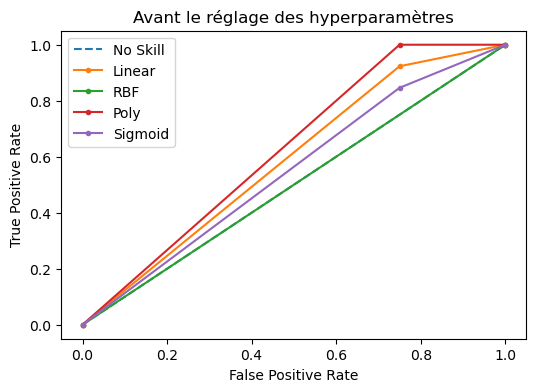

In [33]:
plt.figure(figsize=(6,4))

# plot no skill roc curve
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')

# calculate roc curve for logistic regression
#fpr, tpr, _ = roc_curve(Y_test, Y_pred_logreg_probas[:,1])
#plt.plot(fpr, tpr, marker='.', label='Logistic')

# calculate roc curve for linear kernel
fpr_lin, tpr_lin, _ = roc_curve(Y_test, Y_pred)
plt.plot(fpr_lin, tpr_lin, marker='.', label='Linear')

# calculate roc curve for rbf kernel
fpr_rbf, tpr_rbf, _ = roc_curve(Y_test, Y_pred_rbf)
plt.plot(fpr_rbf, tpr_rbf, marker='.', label='RBF')

# calculate roc curve for poly kernel
fpr_poly, tpr_poly, _ = roc_curve(Y_test, Y_pred_poly)
plt.plot(fpr_poly, tpr_poly, marker='.', label='Poly')

# calculate roc curve for sigmoid kernel
fpr_sig, tpr_sig, _ = roc_curve(Y_test, Y_pred_sig)
plt.plot(fpr_sig, tpr_sig, marker='.', label='Sigmoid')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Avant le réglage des hyperparamètres')

# show the legend
plt.legend()


# show the plot
plt.show()



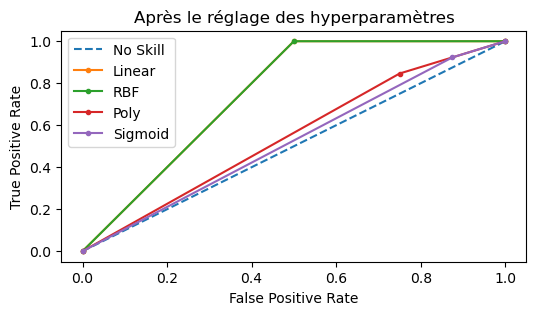

In [35]:
plt.figure(figsize=(6,3))

# plot no skill roc curve
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')

# calculate roc curve for logistic regression
#fpr, tpr, _ = roc_curve(Y_test, Y_pred_logreg_probas[:,1])
#plt.plot(fpr, tpr, marker='.', label='Logistic')

# calculate roc curve for linear kernel
fpr_lin, tpr_lin, _ = roc_curve(Y_test, Y_pred_tuning)
plt.plot(fpr_lin, tpr_lin, marker='.', label='Linear')

# calculate roc curve for rbf kernel
fpr_rbf, tpr_rbf, _ = roc_curve(Y_test, Y_pred_tuning_rbf)
plt.plot(fpr_rbf, tpr_rbf, marker='.', label='RBF')

# calculate roc curve for poly kernel
fpr_poly, tpr_poly, _ = roc_curve(Y_test, Y_pred_tuning_poly)
plt.plot(fpr_poly, tpr_poly, marker='.', label='Poly')

# calculate roc curve for sigmoid kernel
fpr_sig, tpr_sig, _ = roc_curve(Y_test, Y_pred_tuning_sig)
plt.plot(fpr_sig, tpr_sig, marker='.', label='Sigmoid')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Après le réglage des hyperparamètres')


# show the legend
plt.legend()


# show the plot
plt.show()


**c) Qualitative Results** Using your best model, show some of the test images and write on the title the predictions vs the ground truth labels

In [ ]:
# Show some results
width=20
height=15
plt.rcParams['figure.figsize'] = [width, height]

#Change your predictions vector here
Y_best=Y_rbfBest

fig=plt.figure()
imCounter = 1
for i in range(len(Y_test)):
    image=np.reshape(X_test[i,:], (imHeight,imWidth))

    plt.subplot(5,7,imCounter)
    plt.imshow(image,cmap='gray')
    plt.axis('off')
    gtLabel = labelNames[Y_test.ravel()[i].astype(int)]
    predLabel = labelNames[Y_best.ravel()[i].astype(int)]
    plt.title('GT: {}. \n Pred: {}'.format(gtLabel, predLabel))

    imCounter += 1
plt.show()


**d) REPORT:**  Change the hyperparameters of your SVC trying to optimize the F1 measure for different cases. Describe in your report the different variants of the model tried. Present and discuss your findings for different hyperparameters, number of classes and numbers of images. THIS IS THE MOST IMPORTANT PART FOR THE EVALUATION.  